In [96]:
participant_id = "P1"

In [97]:
%load_ext autoreload
%autoreload 2
from hireverse.utils.utils import *

VID_FILE_PATH = BASE_DIR + "/data/raw/videos"
OUTPUT_CSV_FILE = BASE_DIR + "/data/processed/interview_features.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from hireverse.utils.face_analyzer import FaceAnalyzer

face_analyzer = FaceAnalyzer()
frames = face_analyzer.get_video_frames_for_participant(
    participant_id, VID_FILE_PATH, num_selected_frames=25)

# Lexical Features

In [100]:
# from src.utils.LexicalAnalyser import LexicalAnalyser

# AUDIO_FILE_PATH = f"../../data/raw/audio/trimmed_{participant_id}.wav"
# lexical_analyser = LexicalAnalyser(AUDIO_FILE_PATH)
# # Extract all features
# lexical_features = lexical_analyser.extract_all_features()

# # Print the extracted features
# print(lexical_features)

# Facial Features

### Face Mesh

In [101]:
for frame in frames:
    detected_faces_landmarks = face_analyzer.process_image_results(frame.image)
    frame.facial_landmarks_obj= face_analyzer.get_largest_face_landmarks_obj(frame.image, detected_faces_landmarks)
    if frame.facial_landmarks_obj:
        frame.facial_landmarks = frame.facial_landmarks_obj.landmark

### Face

In [102]:

for frame in frames:
    if frame.facial_landmarks:
        frame.face = face_analyzer.get_face_coordinates(frame.facial_landmarks, frame.image)

### Smile

In [103]:
import numpy as np

SMOOTH_WINDOW = 5
happiness_buffer = []
def smooth_happiness(happiness_prob):
    if happiness_prob is None:
        return 0 # TODO: change?
    happiness_buffer.append(happiness_prob)
    if len(happiness_buffer) > SMOOTH_WINDOW:
        happiness_buffer.pop(0)
    return np.mean(happiness_buffer)


for i, frame in enumerate(frames):
    face_roi = face_analyzer.get_face_roi_image(frame.image, frame.face, expand_ratio=1.1)
    frame.smile = smooth_happiness(face_analyzer.get_smile_from_frame(face_roi))

Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


### Selected Facial Features

In [104]:
for frame in frames:
    frame.two_landmarks_connectors = face_analyzer.get_selected_facial_landmarks(frame.facial_landmarks)

### Head Pose

In [105]:
texts = []
for frame in frames:
    result = face_analyzer.get_face_angles(frame.image, frame.facial_landmarks)
    frame.face_angles = result

# Prosodic Extraction

In [106]:
from hireverse.schemas.model_features import ProsodicFeatures
from hireverse.utils.prosody_analyzer import ProsodyAnalyzer
print(BASE_DIR)

prosody_analyzer = ProsodyAnalyzer(participant_id)
prosodic_features: ProsodicFeatures = prosody_analyzer.extract_all_features()
print(prosodic_features)

/Users/bassel27/personal_projects/hireverse
ProsodicFeatures(f0_mean=138.8311168142939, f0_min=75.34559605984698, f0_max=599.1469508185926, f0_range=523.8013547587456, f0_sd=67.08530112931376, intensity_mean=-17.989479064941406, intensity_min=-36.43029022216797, intensity_max=0.0, intensity_range=36.43029022216797, intensity_sd=7.597977638244629, f1_mean=626.2173706460609, f1_sd=255.618004717988, f2_mean=1801.0016796933116, f2_sd=369.19335979732216, f3_mean=2718.6018206978147, f3_sd=363.6766279398512, f2_f1_mean=3.2093469178503944, f3_f1_mean=4.813353523730503, f2_f1_sd=1.1984938994193113, f3_f1_sd=1.5116794397601092, jitter=0.02250039669976796, shimmer=0.17853661247111466, percent_unvoiced=14.22418608114985, percent_breaks=1.6075754239154016, max_pause_duration=2.429999999999999, avg_pause_duration=0.31397260273972616, duration=161.134)


# Features Storage

### Facial Features Aggregation

In [107]:
from hireverse.utils.feature_storage import FeatureStorage

feature_storage = FeatureStorage(OUTPUT_CSV_FILE)
facial_features = feature_storage.aggregate_facial_features(frames)

In [108]:
feature_storage.save_to_csv(participant_id, facial_features, prosodic_features)

# Display Frames

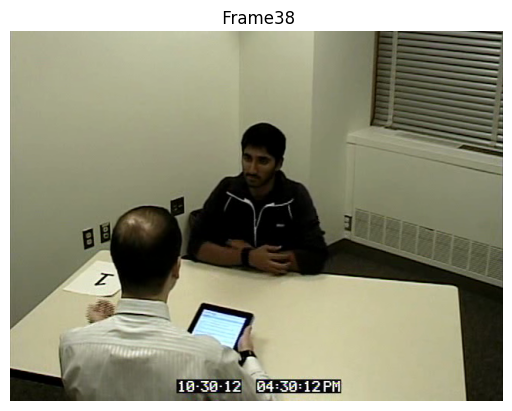

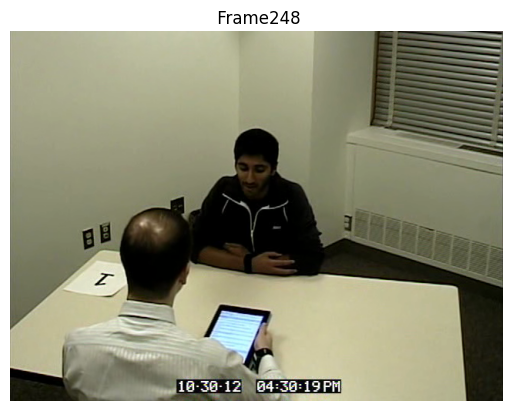

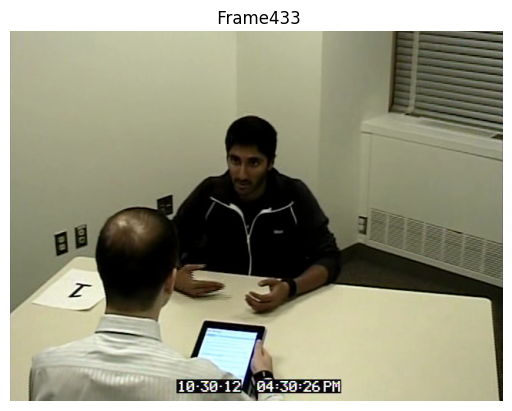

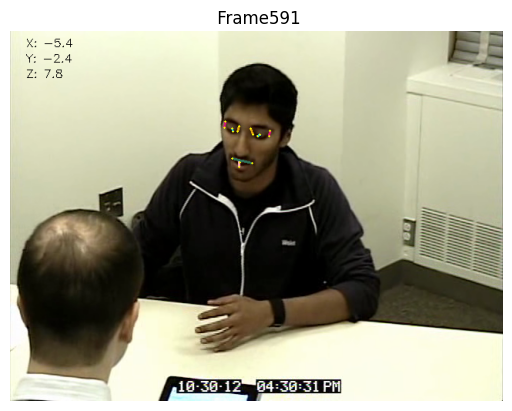

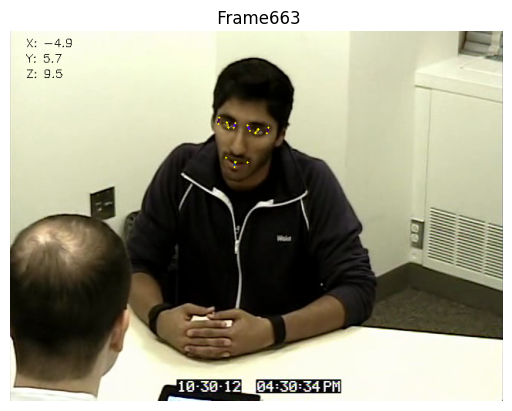

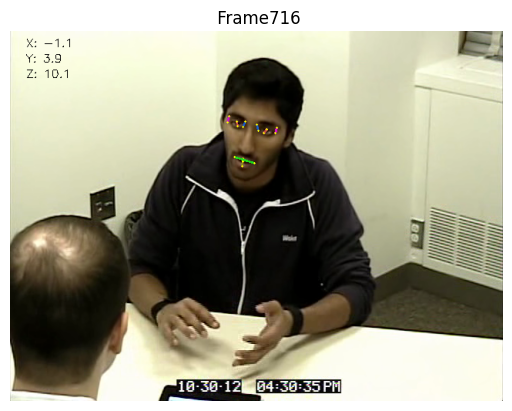

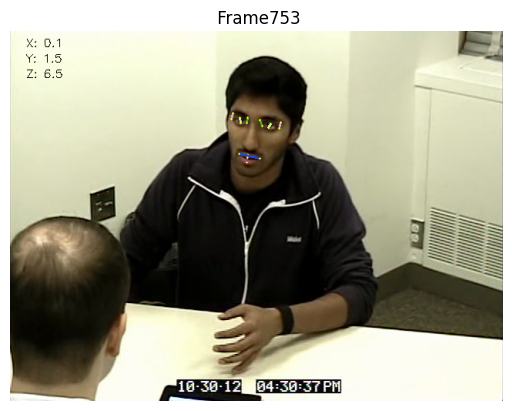

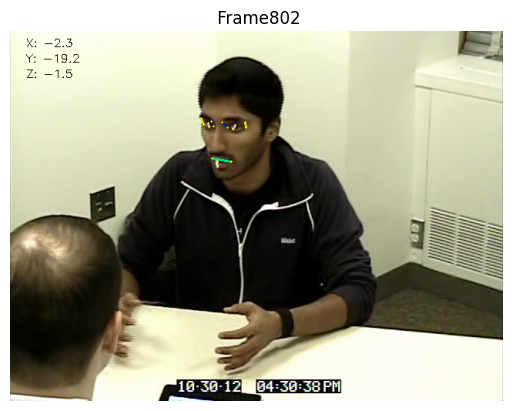

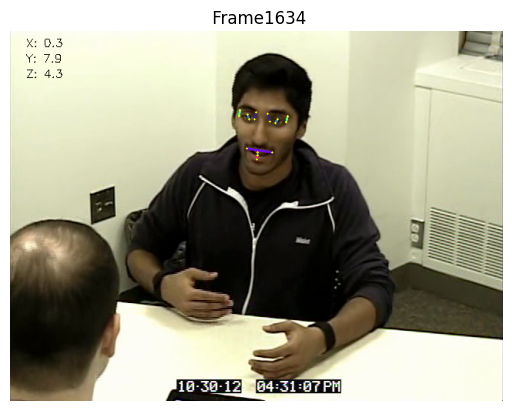

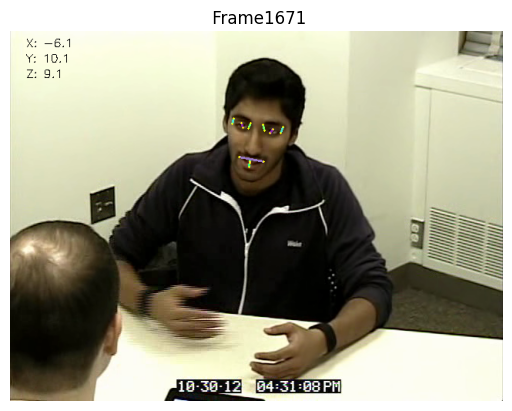

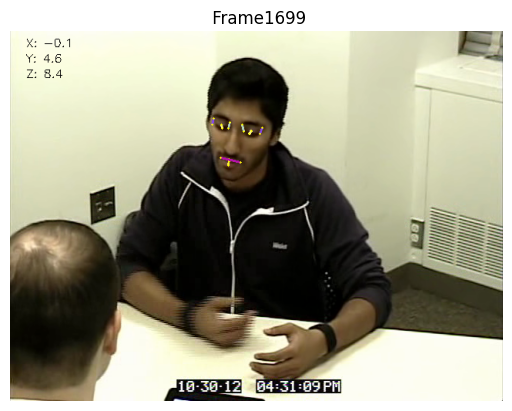

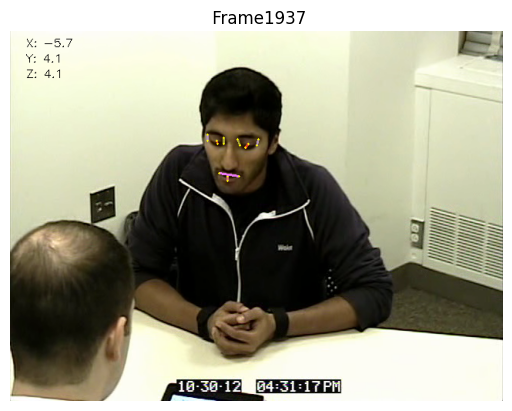

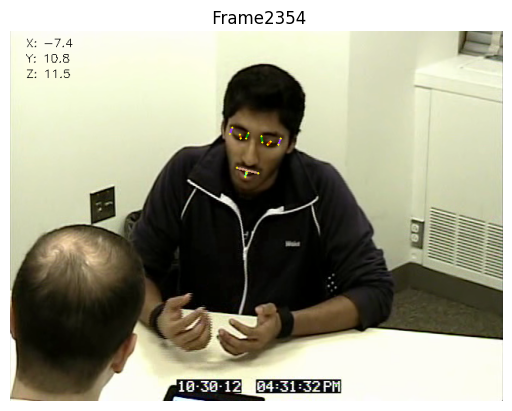

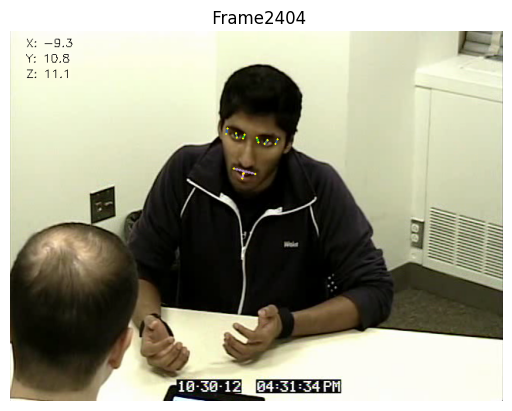

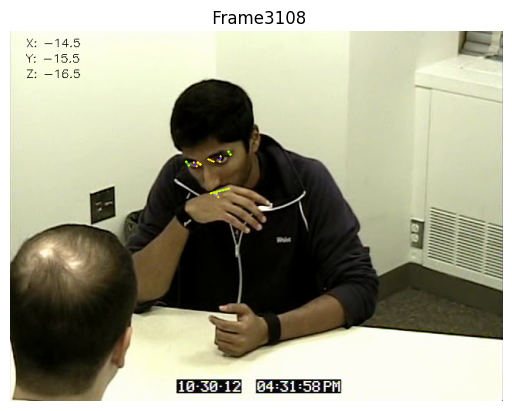

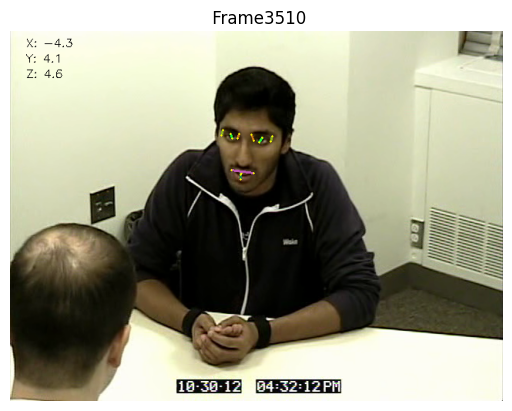

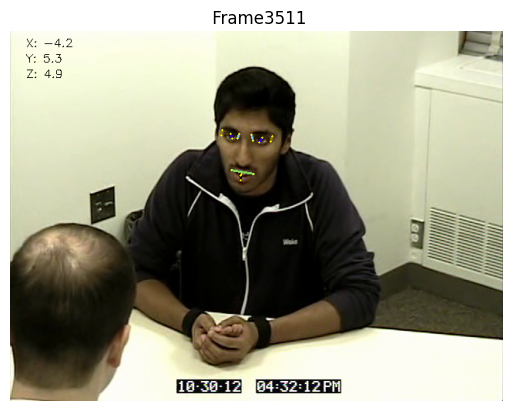

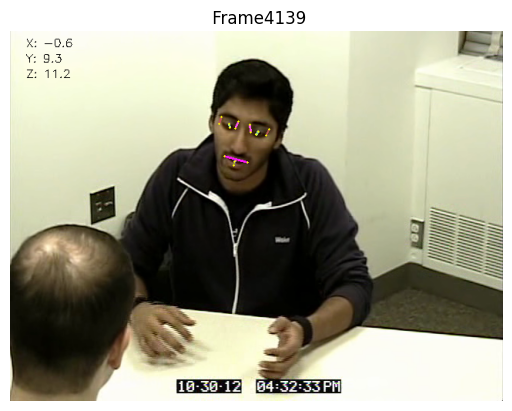

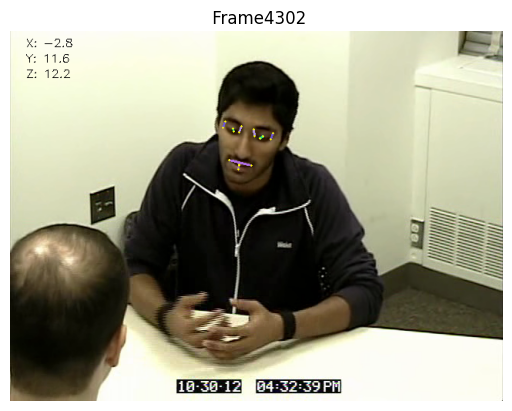

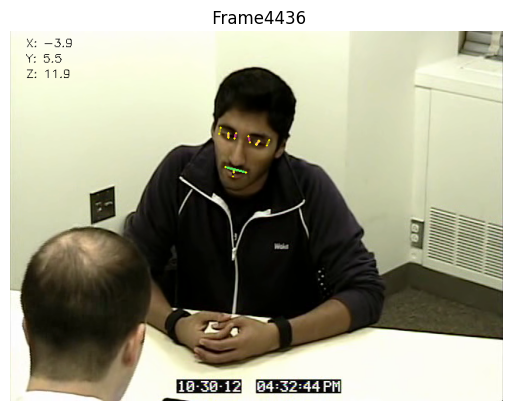

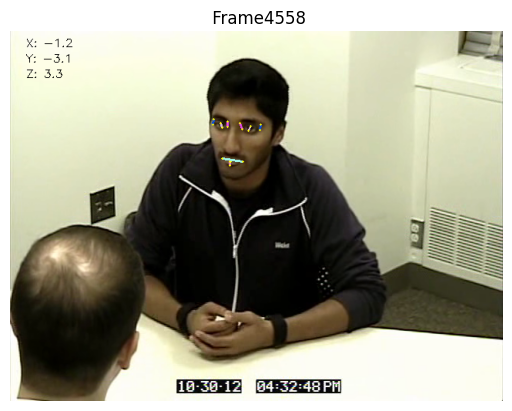

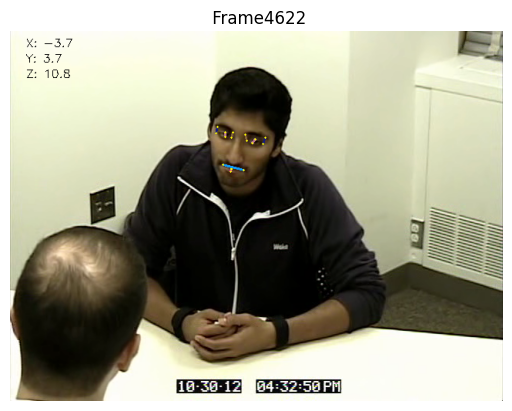

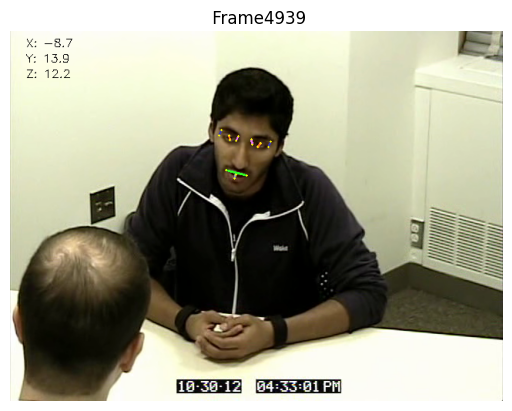

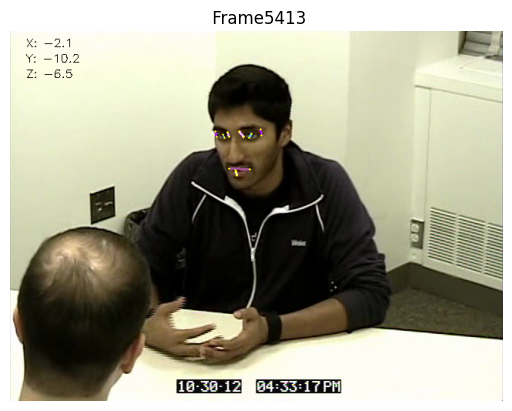

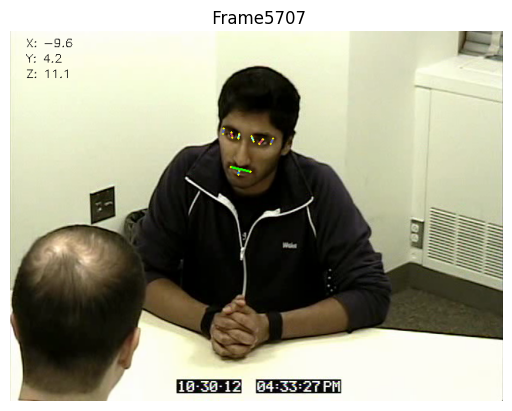

In [109]:
for frame in frames:
    frame.reset_drawable_image()
    # frame.draw_face_border()
    
    frame.draw_selected_facial_landmarks(draw_lines=True)
    
    frame.put_face_angles()
    # frame.draw_facial_landmarks()
    frame.display()